<a href="https://colab.research.google.com/github/ashikshafi08/Learning_Tensorflow/blob/main/Notebooks/Milestone_Project_2_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit
The purpose of this notebook is to build an NLP model to make reading medical abstracts easier. 

In this project, we're going to be putting what we've learned into practice.

More specificially, we're going to be replicating the deep learning model behind the 2017 paper [PubMed 200k RCT: a Dataset for Sequenctial Sentence Classification in Medical Abstracts](https://arxiv.org/abs/1710.06071).

When it was released, the paper presented a new dataset called PubMed 200k RCT which consists of ~200,000 labelled Randomized Controlled Trial (RCT) abstracts.

The goal of the dataset was to explore the ability for NLP models to classify sentences which appear in sequential order. In other words, given the abstract of a RCT, what role does each sentence serve in the abstract?

### What we're going to cover
Time to take what we've learned in the NLP fundmentals notebook and build our biggest NLP model yet:
- Downloading a text dataset (PubMed RCT200k from GitHub)
- Writing a preprocessing function to prepare our data for modelling
- Setting up a series of modelling experiments
  - Making a baseline (TF-IDF classifier)
  - Deep models with different combinations of: token  embeddings, character embeddings, pretrained embeddings, positional embeddings
- Building our first multimodal model (taking multiple types of data inputs).
  - Replicating the model architecture from [paper](https://arxiv.org/pdf/1612.05251.pdf)
- Find the most wrong predictions
- Making predictions on PubMed abstracts from the wild

### Get Data 
Let's download the PubMed 200k PCT data. 
https://github.com/Franck-Dernoncourt/pubmed-rct

In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 0), reused 0 (delta 0), pack-reused 30
Unpacking objects: 100% (33/33), done.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md



Checking the contents of the downloaded repository, you can see there are four folders.

Each contains a different version of the PubMed 200k RCT dataset.

Looking at the README file from the GitHub page, we get the following information:


- PubMed 20k is a subset of PubMed 200k. I.e., any abstract present in PubMed 20k is also present in PubMed 200k.
- PubMed_200k_RCT is the same as PubMed_200k_RCT_numbers_replaced_with_at_sign, except that in the latter all numbers had been replaced by @. (same for PubMed_20k_RCT vs. - PubMed_20k_RCT_numbers_replaced_with_at_sign).
- Since Github file size limit is 100 MiB, we had to compress PubMed_200k_RCT\train.7z and PubMed_200k_RCT_numbers_replaced_with_at_sign\train.zip. To uncompress train.7z, you may use 7-Zip on Windows, Keka on Mac OS X, or p7zip on Linux.

To begin with, the dataset we're going to be focused on is PubMed_20k_RCT_numbers_replaced_with_at_sign.

Why this one?

Rather than working with the whole 200k dataset, we'll keep our experiments quick by starting with a smaller subset. We could've chosen the dataset with numbers instead of having them replaced with @ but we didn't.
Let's check the file contents.

- Paper for Modelling : https://arxiv.org/abs/1612.05251
- Application paper: https://arxiv.org/abs/1710.06071

**Problem in a sentence**

The number of RCT papers released is continuing to increase, those without structured abstracts can be hard to read and in turn slow down researchers moving through the literature.

**Solution in a sentence**

Create an NLP model to classify abstract sentences into the role they play (e.g. objective, methods, results, etc) to enable researchers to skim through the literature (hence SkimLit 🤓🔥) and dive deeper when necessary.

In [2]:
# Check what files are in the PubMed_20k dataset 
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [3]:
# # Start our experiments using thhe 20K dataset with numbers replaced by '@' sign
data_dir = 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

# Check all of the filenames in the target direcotry 
import os 
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data 

Now we've got some text data, it's time to become one with it. 
And one of the best ways to become one with the data is to... 

> Visualize , Visualize , visualize....

So with that in mind, lets write a function to read in all of the lines of a target text file. 

In [4]:
# Create function to read the lines of a document 
def get_lines(filename):
  '''
  Reads filename (a text filename) adn returns the line of text as a list. 

  Args: 
    filename: a string containing the target filepth 

 Returns: 
  A list of stings with one string per line from the target filename
  '''
  with open(filename , 'r') as f: 
    return f.readlines()

In [5]:
# Using our function , lets read in training lines 
train_lines = get_lines(data_dir + 'train.txt') # read the lines within the training file 
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

We can't pass this train lines straight into our model because they are quite messy and our model will start to learning something irrelavant. 

But we can turn this lines into our desired way from which our model can learn. 
- Every new abstract starts with a **###somenumbers** so we can differentiate between different abstracts through this.
- And every label is at the starting line of the sentence, for instance **OBJECTIVE , METHODS** these are present at the very starting line of a sentence.
- Each abstract ends with an **\n** new line command.


Lets think about how we want our data to look...

How the data would be best represented? 

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]
```


In [6]:
# Number of lines 
len(train_lines)

210040

Let's write a function to perform the following steps:

- Take a target file of abstract samples.
- Read the lines in the target file.
- For each line in the target file:
  - If the line begins with ### mark it as an abstract ID and the beginning of a new abstract.
    - Keep count of the number of lines in a sample.
  - If the line begins with \n mark it as the end of an abstract sample.
    - Keep count of the total lines in a sample.
  - Record the text before the \t as the label of the line.
  - Record the text after the \t as the text of the line.
- Return all of the lines in the target text file as a list of dictionaries containing the key/value pairs:
- "line_number" - the position of the line in the abstract (e.g. 3).
- "target" - the role of the line in the abstract (e.g. OBJECTIVE).
- "text" - the text of the line in the abstract.
- "total_lines" - the total lines in an abstract sample (e.g. 14).
- Abstract ID's and newlines should be omitted from the returned preprocessed data.


Example returned preprocessed sample (a single line from an abstract):

```
[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
  ...]

```

In [7]:
def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list
    
    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line
  return abstract_samples

In [8]:
# Using the above function on our data samples
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt") 
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 446 ms, sys: 96.3 ms, total: 542 ms
Wall time: 540 ms


In [9]:
# Check the first abstract of our training data
train_samples[:14]


[{'line_number': 0,
  'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'total_lines': 11},
 {'line_number': 1,
  'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'total_lines': 11},
 {'line_number': 2,
  'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'total_lines': 11},
 {'line_number': 3,
  'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'total_lines': 11},
 {'line_number': 4,
  'target': 'METHODS',
  'text': 'secondary outcome measures include

In [10]:
# Turning our dictionary into a DataFrame for better visualization
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [11]:
# Distributions of labels (checking the balance spread of our labels)
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

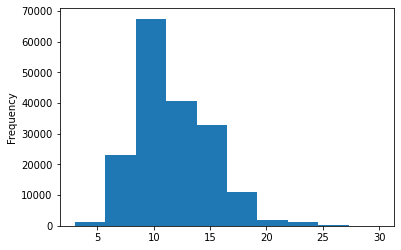

In [12]:
# Distribution of our abstract length (spread of the abstract lines)
train_df.total_lines.plot.hist()

It looks like most of the abstracts are around 7 to 15 sentences in length. 

### Get a list of sentences 

While building a model the main inputs will be a list of strings (the line of the abstract). 

Lets get that lines from our dataframe by calling `tolist()`.

In [13]:
# Convert abstract text lines from df to a lists 
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

# Printing the shapes of the sentences 
print(len(train_sentences) , len(val_sentences) , len(test_sentences) )

180040 30212 30135


In [14]:
# View the first 10 lines of the training sentences 
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make Numeric Labels (convert our labels into numbers) 

We will be building two types of methods: 
- One hot encoding --> For the TensorFlow 
- Label Encoder --> For the Baseline (w/o tensorflow)

In [15]:
# One hot encode labels 
from sklearn.preprocessing import OneHotEncoder

# Instantiating as a method 
one_hot_encoder = OneHotEncoder(sparse = False)

# Performing One hot encoding to our labels 
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1 , 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1 , 1))

# Checking the length 
print(len(train_labels_one_hot) , len(val_labels_one_hot) , len(test_labels_one_hot))

180040 30212 30135


In [16]:
# Checking a example of our. train labels one hot encoded 
train_labels_one_hot[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

### Label encode labels

In [17]:
# Extract labels ('target' columns) and encode them into integers 
from sklearn.preprocessing import LabelEncoder

# Instantiating a method 
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

# Check how the training labels looks like 
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

A great functionality of `LabelEncoder` is we can get the class names and number of classes using the `classes_attribute`.

In [18]:
# Get class names and number of classes from LabelEncoder instance 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_


# Looking inside how it looks like
num_classes , class_names

(5, array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## **Creating a series of model experiments**

We've preprocessed our data, so the next step would be performing some series of modelling experiments. 

At first like always let's build a baseline model and obtain a score from that. Then we'll try to beast that score by building more and more complex models. 

For each model, we'll train it on the training data and evaluate on the validation data.

### Model 0: Getting a baseline 

Our first model will be a TF-IDF Multinomial Naive Bayes. For this we will create a Scikit-learn Pipeline which uses the `TfidVectorizer` class to convert our abstract sentences to number using the **TF-IDF** algorithm and then learns to classify our sentences using the `MultiNomial` algorithm. 

In [19]:
# Building a sklearn Pipeline for our baseline model 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Creating a pipeline 
model_0 = Pipeline([
  ('tf-idf', TfidfVectorizer()), 
  ('clf' , MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X = train_sentences , 
            y = train_labels_encoded)

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('clf',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [20]:
# Evaluating our baseline model on the validation data 
model_0.score(X = val_sentences, 
              y = val_labels_encoded)

0.7218323844829869

In [21]:
# Making predictions on the val sentences
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [22]:
# Creating a function to calculate the evaluation metircs 

def calculate_metrics(y_true , y_preds):
  '''
  Arguments: 
  y_true --> true labels of the data 
  y_preds --> predicted labels of the data 

  Returns: 
  A dictionary of evaluation metrics like precision , recall and f1_score
  '''

  # Let's first import the needed metrics 
  from sklearn.metrics import precision_score , f1_score , accuracy_score , recall_score

  # Creting the metrics 
  accuracy = accuracy_score(y_true , y_preds)
  f1_score = f1_score(y_true , y_preds , average = 'weighted')
  precision = precision_score(y_true , y_preds , average = 'weighted')
  recall = recall_score(y_true , y_preds , average = 'weighted')

  # Now will create a dictionary of these metrics and pack them
  evaluation_dict = {'Accuracy:': accuracy * 100 , 
                     'F1_Score: ': f1_score , 
                     'Precision: ': precision , 
                     'Recall: ': recall }

  # Return our dictionary 
  return evaluation_dict

`macro` --> Insensitive to the label imabalance 
`micro` --> takes in account of the fp,fn etc.. 


In [23]:
# Getting the evaluation metrics dict for our model 
baseline_results = calculate_metrics(val_labels_encoded , baseline_preds)
baseline_results

{'Accuracy:': 72.1832384482987,
 'F1_Score: ': 0.6989250353450294,
 'Precision: ': 0.7186466952323352,
 'Recall: ': 0.7218323844829869}

Thats great! We got our baseline results now lets do some more preprocessing works on our data so we can build a deep sequence model with it. 

## Preparing our data for deep sequence models 

Before we start building deep models we gotta create vectorization and Embedding layers. 

In [24]:
import numpy as np 
import tensorflow as tf 
from tensorflow.keras import layers 

Before jumping into the modelling we have to do some analysis on our data so that it will be quite appropriate for us to converting our text into numbers. 

Its a good idea to figure out how many words are in each sentence. Because when our model goes through our sentences, it **works best when they're all at the same length (crucial for creating batches).** 

> For example, if one sentence is eight words long and another in 29 words long, we want to pad the eight word sentence with zeros so it ends up being the same length as the 29 word sentence. 

In [25]:
# How long is each sentence on average? (spread of sentence len)
sent_lens = [len(sentence.split()) for sentence in train_sentences]

# Taking average of the sentence lens 
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <a list of 20 Patch objects>)

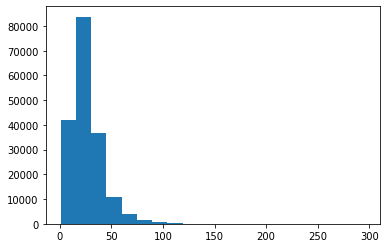

In [26]:
# Whats the distribution look like? 
import matplotlib.pyplot as plt
plt.hist(sent_lens , bins = 20)

Our vast majority of sentence lengths are between 0 to 50 tokens in length. It would be ideal if we pad all the sentences to 50. 

Lets see in % to find the value which covers 95% of the sentence lengths. 

In [27]:
# How long a sentence covers 95% of the lengths? 
output_seq_len = int(np.percentile(sent_lens , 95))
output_seq_len

55

It seems the 95% of the sentences in our training set have a length of 55 tokens or less. 

When we create our tokenization layer, we will use this value to turn all our sentences into the same length. 

That means sentences with a length below 55 get padded with zeros and sentences with a length above 55 get truncated. 

In [28]:
# Maximum seq lenght in our training set 
max(sent_lens) # Something is 296 words long 

296

#### Create a text vectorizer layer 
Now we got some infos abour our data we can now turn our text into numbers.

The first step we would do is turning our texts into tokens by using the text_vectorizer layer from TensorFlow. 

In [29]:
# Creating a text vectorizer layer 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Variables for our text vectorizer layer 
max_vocab = 68000 # from the paper (taken from 3.2 in https://arxiv.org/pdf/1710.06071.pdf)

# Creating the layer 
text_vectorizer = TextVectorization(max_tokens= max_vocab , 
                                    output_sequence_length = output_seq_len , 
                                    output_mode = 'int')

# Calling the adapt method on our train sentences so our inherits the texts 
text_vectorizer.adapt(train_sentences)

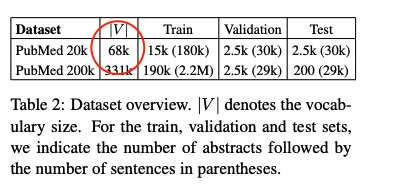

In [30]:
# Looking into our test vectorizer 
import random 
target_sentence = random.choice(train_sentences)
print(f'Text:\n {target_sentence}')
print(f'\nLength of text: {len(target_sentence.split())}')
print(f'\nVectorized text:\n {text_vectorizer([target_sentence])}')

Text:
 dietary patterns that are considered healthy ( eg , the dietary approaches to stop hypertension diet and mediterranean diet ) may be more successful in reducing typical cardiovascular disease risks compared to dietary patterns considered unhealthy ( eg , energy-dense diets such as the typical american diet ) .

Length of text: 49

Vectorized text:
 [[  566  1429    28    58   535   247  1268     2   566  1326     6  4406
    659   376     3  4152   376    91    36    69   845     5   451  4007
    323   114  1405    34     6   566  1429   535  5312  1268 26663  1891
    345    25     2  4007  1035   376     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [31]:
# How many words in our training vocabulary 
rct_20k_text_vocab = text_vectorizer.get_vocabulary() 

# Printing the top 5 and least 5 
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"), 
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 64841
Most common words in the vocabulary: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocabulary: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [32]:
# Configuratio of our Text vectorizer 
text_vectorizer.get_config()

{'dtype': 'string',
 'max_tokens': 68000,
 'name': 'text_vectorization',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'split': 'whitespace',
 'standardize': 'lower_and_strip_punctuation',
 'trainable': True,
 'vocabulary_size': 64841}

#### Create a custom text embedding 

Out `text_vectorization` helps to map the words in our text directly to numbers but yet it doesn't necessarily caputre the relationships between those numbers. 

We use **embedding**, to create a richer numerical representation of our text. 

As our model learns by going through the test, it will update its embedding to better represent the relationships betwen the tokens in our corpus (vocab).

The main parameter we're concerned here is the input_dim and output_dim of our Embedding layer. 

- `input_dim` --> defines the size of our vocabulary 
- `output_dim` --> defines the dimensions of the embedding output. 

Our embedding layer will take the integer outputs of our text_vectorization layer as inputs and convert them to feature vectors of size `output_dim`

**Links**: 
- https://stackoverflow.com/questions/47485216/how-does-mask-zero-in-keras-embedding-layer-work/61102319#61102319
- https://www.tensorflow.org/guide/keras/masking_and_padding

In [33]:
# Create a token embedding layer 
token_embed = layers.Embedding(input_dim= len(rct_20k_text_vocab) , 
                               output_dim = 128  , # different embedding sizes result in drastically different numbers of parameters to train
                               mask_zero = True, 
                               name ='token_embedding')

In [34]:
# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
dietary patterns that are considered healthy ( eg , the dietary approaches to stop hypertension diet and mediterranean diet ) may be more successful in reducing typical cardiovascular disease risks compared to dietary patterns considered unhealthy ( eg , energy-dense diets such as the typical american diet ) .

Sentence after vectorization (before embedding):
[[  566  1429    28    58   535   247  1268     2   566  1326     6  4406
    659   376     3  4152   376    91    36    69   845     5   451  4007
    323   114  1405    34     6   566  1429   535  5312  1268 26663  1891
    345    25     2  4007  1035   376     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.02123742 -0.04451612  0.0315328  ...  0.0367718   0.04229286
    0.02266343]
  [-0.01341202  0.02050182 -0.02550992 ...  0.04290228 -0.00171821
   -0.01539301]
  [ 0.02479298 -0.00259359  0.02364571 ... -0.02709389 -0.03084715
   -0

Our each vector will be the size of 128 long vectors. 

#### Create datasets (as fast as possible) 

Now its time to pack our texts into datasets to be used with a ml model, now we will look into some methods to make the process faster. 

- We will use a `PrefetchDataset` of batches (will use prefetch). Doing so we'll ensure TensorFlow loads our data onto the GPU as fast as possible, so faster training time. 
- We will use `batch()` and `prefetch()`and `tf.data.AutoTune` will help us to determine optimal amount of compute to use to prepare datasets. 

In [35]:
# Turn our data into TensorFlow Datasets 
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences , train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences , val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences , test_labels_one_hot))

# Looking into our train dataset 
train_dataset

<TensorSliceDataset shapes: ((), (5,)), types: (tf.string, tf.float64)>

In [36]:
# Applying batch and prefetch on our dataset 
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


train_dataset

<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>

### Model 1: Conv1D with token embeddings 

So far we got everything we needed to model our data. Our deep models will follow a similar structure: 

```
Input (text) -> Tokenize -> Embedding -> Layers -> Output (label probability)
```
We will be changing some Layers components, because the modern deep NLP models requires text to be converted into embedding before meaningful patterns can be discovered within. 

The first model we're going to build is a 1-dimensional Convolutional Neural Networks. And we will follow the below workflow: 
- Build Model 
- Train Model 
- Evaluate model (make preds and compare with the ground truth). 

In [37]:
# Building the Conv1D model to process sequences 
inputs = layers.Input(shape = (1, ),  dtype= tf.string)

# Preprocessing layers 
text_vectors = text_vectorizer(inputs) # vectorize text inputs 
token_embeddings = token_embed(text_vectors) # create embedding 

# Conv1D layer 
x = layers.Conv1D(filters= 64 , kernel_size= 5 , padding= 'same' , activation= 'relu')(token_embeddings)
x = layers.GlobalMaxPooling1D()(x) # condense the output of our feature vector(patterns learned by our model)

# output layer 
outputs = layers.Dense(num_classes , activation= 'softmax')(x)

# Packing into a model 
model_1 = tf.keras.Model(inputs , outputs)

# Compile the model
model_1.compile(loss = tf.keras.losses.CategoricalCrossentropy() , # because of one hot encoded labels
                optimizer = tf.keras.optimizers.Adam() , 
                metrics = ['accuracy'])


# Summary of our model 
model_1.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
text_vectorization (TextVect (None, 55)                0         
_________________________________________________________________
token_embedding (Embedding)  (None, 55, 128)           8299648   
_________________________________________________________________
conv1d (Conv1D)              (None, 55, 64)            41024     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 8,340,997
Trainable params: 8,340,997
Non-trainable params: 0
___________________________________________________

By looking at the model summary we can notice the majority of the trainable parameters are within the embedding layer. And if we're to increase the size of the embedding layer (output_dim) the number of trainable parameters would increase dramatically. 

We will use only the first 10% of batches (about 18k samples) of the training set to train and first 10% of batches from the validation set to validate on. 

> **🔑 Note:** It's a standard practice in machine learning to test your models on smaller subsets of data first to make sure they work before scaling them to larger amounts of data. You should aim to run many smaller experiments rather than only a handful of large experiments. And since your time is limited, one of the best ways to run smaller experiments is to reduce the amount of data you're working with (10% of the full dataset is usually a good amount, as long as it covers a similar distribution).

We are conduction experiments on our data so we train only on 10% of the data. This is to ensure we speed up our experimentation. 

In [38]:
int(0.1 * len(train_dataset)) * 32 # Num of samples

17984

In [39]:
# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 60s 79ms/step - loss: 0.8424 - accuracy: 0.6810 - val_loss: 0.5815 - val_accuracy: 0.7876
Epoch 2/3
562/562 [==============================] - 44s 79ms/step - loss: 0.5762 - accuracy: 0.7893 - val_loss: 0.5360 - val_accuracy: 0.8042
Epoch 3/3
562/562 [==============================] - 44s 79ms/step - loss: 0.5430 - accuracy: 0.8013 - val_loss: 0.5178 - val_accuracy: 0.8062


In [40]:
# Evaluate the model on a whole validation dataset 
model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5221 - accuracy: 0.8068


[0.5220773220062256, 0.8067986369132996]

In [41]:
# Make predictions (our model outputs prediction probabilties for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs

array([[5.89723766e-01, 1.16141535e-01, 5.06118918e-03, 2.82712489e-01,
        6.36097649e-03],
       [2.97658503e-01, 5.27617872e-01, 4.09173954e-04, 1.72073305e-01,
        2.24105339e-03],
       [1.71247363e-01, 2.47625150e-02, 2.40417151e-03, 8.01288545e-01,
        2.97413237e-04],
       ...,
       [1.07077321e-04, 1.74943695e-03, 6.19245507e-03, 7.47379017e-05,
        9.91876245e-01],
       [1.14513496e-02, 4.57819372e-01, 2.60708369e-02, 7.97531847e-03,
        4.96683151e-01],
       [9.06967651e-03, 9.87133741e-01, 9.77143063e-04, 2.22032960e-03,
        5.99036110e-04]], dtype=float32)

In [42]:
# Converting our pred probs to class preds 
model_1_preds = tf.argmax(model_1_pred_probs , axis = 1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [43]:
# Calculate the model 1 results 
model_1_results = calculate_metrics(val_labels_encoded , 
                                    model_1_preds)
model_1_results

{'Accuracy:': 80.67986230636834,
 'F1_Score: ': 0.8049517480858016,
 'Precision: ': 0.804905478647257,
 'Recall: ': 0.8067986230636833}

In [44]:
baseline_results

{'Accuracy:': 72.1832384482987,
 'F1_Score: ': 0.6989250353450294,
 'Precision: ': 0.7186466952323352,
 'Recall: ': 0.7218323844829869}

### Model 2: Feature extraction with pretrained token embeddings 

Rather using a Conv1D model let's use a pretrained token embedding from the Tensorflow Hub. 

The model structure will look like this: 

```
Inputs (string) -> Pretrained embeddings from TensorFlow Hub (Universal Sentence Encoder) -> Layers -> Output (prediction probabilities)
```

> **🔑 Note:** We could use GloVe embeddings as per the paper but since we're working with TensorFlow, we'll use what's available from TensorFlow Hub (GloVe embeddings aren't). We'll save [using pretrained GloVe embeddings](https://keras.io/examples/nlp/pretrained_word_embeddings/) as an extension.


But we dont have a Glove embedding in our TensorFlow Hub, so we will go with our universal  
[sentence encoder layer](https://tfhub.dev/google/universal-sentence-encoder/4) as our pretrained token embedding 

In [45]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub 
tf_hub_embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4' , 
                                        trainable = False , 
                                        name = 'universal_sentence_encoder')

In [46]:
# Test out the embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
vedolizumab did not alter the response to parenterally administered antigens but reduced the response to oral antigens , demonstrating its gut-selective mechanism of action .

Sentence after embedding:
[ 0.01158819  0.01046837 -0.00516023 -0.08278831  0.00441855  0.08162073
  0.04245562 -0.06481582 -0.01794431  0.07837377  0.07287468 -0.02151221
  0.04502997  0.02094643 -0.00447535 -0.06299067 -0.03467832 -0.05148796
  0.00777945 -0.00207086 -0.04901608 -0.01004916 -0.05331867 -0.00841713
 -0.04774833 -0.02320225 -0.05931909 -0.00058589  0.04185677  0.0326224 ] (truncated output)...

Length of sentence embedding:
512


USE module (pretrained embedding) takes care of tokenizing our text for us and outputs 512 dim embedding vector. 

Now lets build a model with our pretrained embedding layer. 

In [47]:
# Building our model with the feature extraction layer 
inputs = layers.Input(shape = [] , dtype= tf.string)

# Our pretrained embedding layer 
pretrained_embedding = tf_hub_embedding_layer(inputs)

# FC layer 
x = layers.Dense(128 , activation = 'relu')(pretrained_embedding)
outputs = layers.Dense(num_classes , activation= 'softmax')(x)

# Packing into a model 
model_2 = tf.keras.Model(inputs , outputs)

# Compile the model 
model_2.compile(loss = tf.keras.losses.CategoricalCrossentropy() , 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics = ['accuracy'])

# Sumamry of the model 
model_2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 645       
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [48]:
# Fit the feature extractor model for 3 epochs 
model_2_history = model_2.fit(train_dataset , 
                              epochs = 3 , 
                              steps_per_epoch = int(0.1 * len(train_dataset)) , 
                              validation_data = valid_dataset , 
                              validation_steps = int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 8s 11ms/step - loss: 0.9174 - accuracy: 0.6505 - val_loss: 0.7967 - val_accuracy: 0.6898
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7682 - accuracy: 0.7022 - val_loss: 0.7551 - val_accuracy: 0.7031
Epoch 3/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7526 - accuracy: 0.7125 - val_loss: 0.7398 - val_accuracy: 0.7091


In [49]:
# Evaluating our model on the whole valid data 
model_2.evaluate(valid_dataset)

945/945 [==============================] - 9s 10ms/step - loss: 0.7416 - accuracy: 0.7126


[0.7416253685951233, 0.712597668170929]

In [50]:
# Make predictions with our feature extraction model 
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

array([[4.2532277e-01, 3.7401783e-01, 2.5746447e-03, 1.9053102e-01,
        7.5537111e-03],
       [3.3984664e-01, 5.0300103e-01, 4.5694802e-03, 1.5014243e-01,
        2.4404167e-03],
       [2.4119483e-01, 1.2392855e-01, 1.9455602e-02, 5.8266395e-01,
        3.2757070e-02],
       ...,
       [1.5108696e-03, 6.2938617e-03, 6.2275674e-02, 7.2321552e-04,
        9.2919636e-01],
       [4.1640489e-03, 4.7597587e-02, 2.1985911e-01, 1.6711343e-03,
        7.2670811e-01],
       [1.8004254e-01, 2.1895149e-01, 5.3031301e-01, 8.0507034e-03,
        6.2642224e-02]], dtype=float32)

In [51]:
# Convert the pred probs to class preds 
model_2_preds = tf.argmax(model_2_pred_probs , axis = 1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [52]:
# Results for our feature extraction model 
model_2_results = calculate_metrics(val_labels_encoded , 
                                    model_2_preds)
model_2_results

{'Accuracy:': 71.25976433205349,
 'F1_Score: ': 0.7095874034305731,
 'Precision: ': 0.7130729403328177,
 'Recall: ': 0.7125976433205349}

In [53]:
label_encoder.classes_

array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
      dtype=object)

### Model 3: Conv1D with character embeddings 

The paper which we're replicating they used a combination of token and character-level embeddings. Previously we've token-level embeddings but we'll need to do similar steps for characters if we want to use char-level embeddings. 

The difference between a character and token embedding is that the **character embedding** is created using sequences split into character (e.g hello --> [h, e, l, l, o] whereas token embedding is created on sequences split into tokens. 

**How to create character-level embbedding?**
We can create a character-level embedding by first vectorizing our sequences (after they have been split into characters) using the `TextVectorization` class and then ppassing those vectorized through an `Embedding` layer. 

In [54]:
# Make function to split sentnces into character 
def split_chars(text):
  return ' '.join(list(text))

# Teest splititng non-character level sequence into characters 
split_chars(random_training_sentence)

'v e d o l i z u m a b   d i d   n o t   a l t e r   t h e   r e s p o n s e   t o   p a r e n t e r a l l y   a d m i n i s t e r e d   a n t i g e n s   b u t   r e d u c e d   t h e   r e s p o n s e   t o   o r a l   a n t i g e n s   ,   d e m o n s t r a t i n g   i t s   g u t - s e l e c t i v e   m e c h a n i s m   o f   a c t i o n   .'

In [55]:
random_training_sentence

'vedolizumab did not alter the response to parenterally administered antigens but reduced the response to oral antigens , demonstrating its gut-selective mechanism of action .'

Create character-level datasets by splitting our sequence datasets into characters. 

#### Character level Text vectorizer

In [56]:
# Split sequence level data splitsi nto character level data spplits 
train_chars = [split_chars(sentence)  for sentence in train_sentences]
valid_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

# Checking the train chars 
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

To figure our how long our vectorized character sequence should be (avg character length), distribution of our character sequence lengths. 

In [57]:
# Whats the average character length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

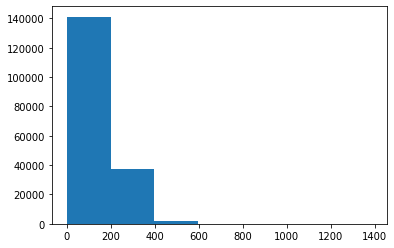

In [58]:
# Chheck the distribution of our sequences at character-level 
import matplotlib.pyplot as plt
plt.hist(char_lens , bins = 7);

In [59]:
# Find what character length covers 95% of sequences 
output_seq_char_len = int(np.percentile(char_lens , 95))
output_seq_char_len

290

Now we know the sequence length which covers 95% of sequences, we will use that in our `TextVectorization` layer as the `output_sequence_length` parameter. 

> **Note**: You can experiment here to figure out what the optimal `output_sequence_length` should be, perhaps using the mean results in as good results using the 95% percentile. 

We'll set `max_tokens` (total number of different characters in our sequences) to 28, in other  words 26 letters of the alphabet + space + OOV tokens. 

In [60]:
# Get all the keyboard character for char-level embedding 
import string 
alphabet = string.ascii_lowercase + string.digits + string.punctuation 
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [61]:
len(alphabet) + 2

70

In [62]:
# Create char-level token vectorized instance 
NUM_CHAR_TOKENS = len(alphabet) + 2 

# Text Vectorizer 
char_vectorizer = TextVectorization(max_tokens= NUM_CHAR_TOKENS , 
                                    output_sequence_length = output_seq_char_len, 
                                    standardize = 'lower_and_strip_punctuation' , 
                                    name ='char_vectorizer')

# Adapt character vectorized to training characters 
char_vectorizer.adapt(train_chars)

In [63]:
# Check character vocabulary characteristics
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab)

28

In [64]:
# Checking our character and the corresponding vectorized chars 
random_train_chars = random.choice(train_chars)
print(f'Charified text:\n {random_train_chars}')
print(f'\n Length of chars: {len(random_train_chars.split())}')
print(f'5 most common character: {char_vocab[:5]}')
print(f'5 least common character: {char_vocab[-5:]}')

Charified text:
 w o m e n   r a n d o m i s e d   t o   l i f e s t y l e   a d v i c e   a l s o   d e m o n s t r a t e d   g r e a t e r   t o t a l   p h y s i c a l   a c t i v i t y   (   a d j u s t e d   d i f f e r e n c e   i n   m e a n s   @   m e t a b o l i c   e q u i v a l e n t   t a s k   u n i t s   (   m e t   )   m i n u t e s / w e e k   ;   @   %   c i   @   t o   @   ;   p   =   @   )   c o m p a r e d   w i t h   w o m e n   r e c e i v i n g   s t a n d a r d   c a r e   .

 Length of chars: 201
5 most common character: ['', '[UNK]', 'e', 't', 'i']
5 least common character: ['k', 'x', 'z', 'q', 'j']


In [65]:
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")



Vectorized chars:
[[20  7 15  2  6  8  5  6 10  7 15  4  9  2 10  3  7 12  4 17  2  9  3 19
  12  2  5 10 21  4 11  2  5 12  9  7 10  2 15  7  6  9  3  8  5  3  2 10
  18  8  2  5  3  2  8  3  7  3  5 12 14 13 19  9  4 11  5 12  5 11  3  4
  21  4  3 19  5 10 27 16  9  3  2 10 10  4 17 17  2  8  2  6 11  2  4  6
  15  2  5  6  9 15  2  3  5 22  7 12  4 11  2 26 16  4 21  5 12  2  6  3
   3  5  9 23 16  6  4  3  9 15  2  3 15  4  6 16  3  2  9 20  2  2 23 11
   4  3  7 14 11  7 15 14  5  8  2 10 20  4  3 13 20  7 15  2  6  8  2 11
   2  4 21  4  6 18  9  3  5  6 10  5  8 10 11  5  8  2  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0]]

Length of vectorized chars: 290


We can notice the sequences with a length shorted than 290 (output_seq_char_lenght) get padded with zeros at the end, this ensures all sequences passed to our model are the same length. 

#### Creating a character-level embedding 
We have created our character-level vectorizer and now its time to create a character level embedding. 

We can do that by using `tf.keras.layers.Embedding(())` where, 
- `input_dim` will be equal to the different characters in our **char_vocab** (28). 
- The output dimension `output_dim` will be 25. 

In [66]:
# Create char embedding layer 
char_embed = layers.Embedding(input_dim= NUM_CHAR_TOKENS, # number of diff characters, 
                              output_dim = 25, #embedding dimension of each character (on the papper)
                              mask_zero = True , 
                              name = 'char_embed')

# Test out character embedding layer 
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")

# Applying the embedding layer on a random sentence
char_embed_example = char_embed(char_vectorizer([random_train_chars])) 

print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
w o m e n   r a n d o m i s e d   t o   l i f e s t y l e   a d v i c e   a l s o   d e m o n s t r a t e d   g r e a t e r   t o t a l   p h y s i c a l   a c t i v i t y   (   a d j u s t e d   d i f f e r e n c e   i n   m e a n s   @   m e t a b o l i c   e q u i v a l e n t   t a s k   u n i t s   (   m e t   )   m i n u t e s / w e e k   ;   @   %   c i   @   t o   @   ;   p   =   @   )   c o m p a r e d   w i t h   w o m e n   r e c e i v i n g   s t a n d a r d   c a r e   .

Embedded chars (after vectorization and embedding):
[[[-0.0458128   0.03302816  0.0248498  ... -0.02773455 -0.03415127
   -0.03344088]
  [ 0.00011716  0.04258357  0.02147638 ...  0.04953246 -0.01315609
    0.03334418]
  [-0.03169139 -0.0038227  -0.02718272 ... -0.02534465  0.02626804
   -0.03292708]
  ...
  [-0.03340246 -0.01415675  0.01978033 ...  0.03633961 -0.03704723
   -0.03716773]
  [-0.03340246 -0.01415675  0.01978033 ...  0.03633961 -0.03704723
 

(1,290,25) --> 1 is the single sequence of 290 long (char sequence) and they are represented as 25 long embedding vector.

#### Building a Conv1D model to fit on character embedding 
Till now we have turned our character-level sequence into numbers (`char_vectorizer`) as well as numerically represent them as an embedding (`char_embed`). 


The model will have te same structure as our custom token embedding model (`model_1`) except it will take **characeter-level sequences** as input instead of **token-level sequences**.

```
Input (character-level text) -> Tokenize -> Embedding -> Layers (Conv1D, GlobalMaxPool1D) -> Output (label probability)

```

In [67]:
# Building the Conv1D Character level sequence model 
inputs = layers.Input(shape = (1,) , dtype = tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x = layers.Conv1D(64 , kernel_size= 5 , padding ='same' , activation= 'relu')(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes , activation= 'softmax')(x)

# Packing into a model 
model_3 = tf.keras.Model(inputs , outputs)

# Compiling the model 
model_3.compile(loss = tf.keras.losses.CategoricalCrossentropy(), 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics = ['accuracy'])
# Checking the model summary
model_3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
char_vectorizer (TextVectori (None, 290)               0         
_________________________________________________________________
char_embed (Embedding)       (None, 290, 25)           1750      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 290, 64)           8064      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 10,139
Trainable params: 10,139
Non-trainable params: 0
_______________________________________________________

In [68]:
# Create char level pre-fetch dataset 
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars , train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((valid_chars , val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


train_char_dataset , val_char_dataset

(<PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>,
 <PrefetchDataset shapes: ((None,), (None, 5)), types: (tf.string, tf.float64)>)

In [69]:
# Fitting thhe model on character level sequence 
model_3_history = model_3.fit(train_char_dataset , 
                              epochs = 3 ,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)) ,
                              validation_data = val_char_dataset , 
                              validation_steps = int(0.1 * len(val_char_dataset)))

Epoch 1/3
562/562 [==============================] - 4s 6ms/step - loss: 1.2729 - accuracy: 0.4805 - val_loss: 1.0350 - val_accuracy: 0.5938
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9966 - accuracy: 0.6056 - val_loss: 0.9241 - val_accuracy: 0.6456
Epoch 3/3
562/562 [==============================] - 3s 5ms/step - loss: 0.9116 - accuracy: 0.6502 - val_loss: 0.8493 - val_accuracy: 0.6755


In [70]:
# Evaluate the model3 on validation set 
model_3.evaluate(val_char_dataset)

945/945 [==============================] - 3s 4ms/step - loss: 0.8720 - accuracy: 0.6665


[0.8719615340232849, 0.6665232181549072]

In [71]:
# Making predictions with our char model 
model_3_pred_probs = model_3.predict(val_char_dataset)
model_3_preds = tf.argmax(model_3_pred_probs , axis = 1)

model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([3, 1, 3, ..., 4, 4, 1])>

In [72]:
# Calculate the result report on our char only model 
model_3_results = calculate_metrics(val_labels_encoded , 
                                    model_3_preds)
model_3_results

{'Accuracy:': 66.65232358003442,
 'F1_Score: ': 0.6586050139207128,
 'Precision: ': 0.6620766566585191,
 'Recall: ': 0.6665232358003442}

### Model 4: Combining pretrained token embeddings + character embeddings (hybrid embedding layer)

Now we are going to build a model that sounds similar from the paper itself. Its time we tackle the hybrid token embedding layer they speak of. 

This hybrid token embedding layer is a **combination of token embeddings and character embeddings**. In other words, they **create a stacked embedding to represent sequences** before passing them to the sequence label prediction layer.

So far we've built two models which have used token and character-level embeddings, however, these two models have used each of these embeddings exclusively.

The steps are as follows: 
- Create a token-level model (similar to model_1)
- Create a character-level model (similar to model_3 with a slight modification to reflect the paper). 
- Combine (using `layers.Concatenate`) the outputs of 1 and 2. 
-Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of [Neural Networks for Joint Sentence Classification in Medical Paper Abstracts](https://arxiv.org/pdf/1612.05251.pdf).
- Construct a model which takes token and character-level sequences as input and produces sequence label probabilities as output

In [73]:
# 1. Setup token inputs/model 
token_inputs = layers.Input(shape = [] , dtype = tf.string , name = 'token_input')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128 , activation = 'relu')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs , 
                             outputs = token_outputs)

# 2. Setup char inputs/model 
char_inputs = layers.Input(shape = (1,) , dtype = tf.string , name='char_input')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings) # bi-lstm shown in figure 1 of the paper 
char_model = tf.keras.Model(inputs = char_inputs ,
                            outputs = char_bi_lstm)

# 3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name = 'token_char_hybrid')([token_model.output , 
                                                                    char_model.output])

# 4. Build a series of output layer similar to the figure 1 (adding Dropout)
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128 , activation = 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation= 'softmax')(final_dropout)

# 5. Construct model with char and token inputs 
model_4 = tf.keras.Model(inputs = [token_model.input , char_model.input] , 
                         outputs =  output_layer , 
                         name = 'model_4_token_and_char_embeddings')

# Getting the summary of the model 
model_4.summary()

Model: "model_4_token_and_char_embeddings"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_input (InputLayer)        [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_input[0][0]                 
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_input[0][0]                
__________________________________________________________________

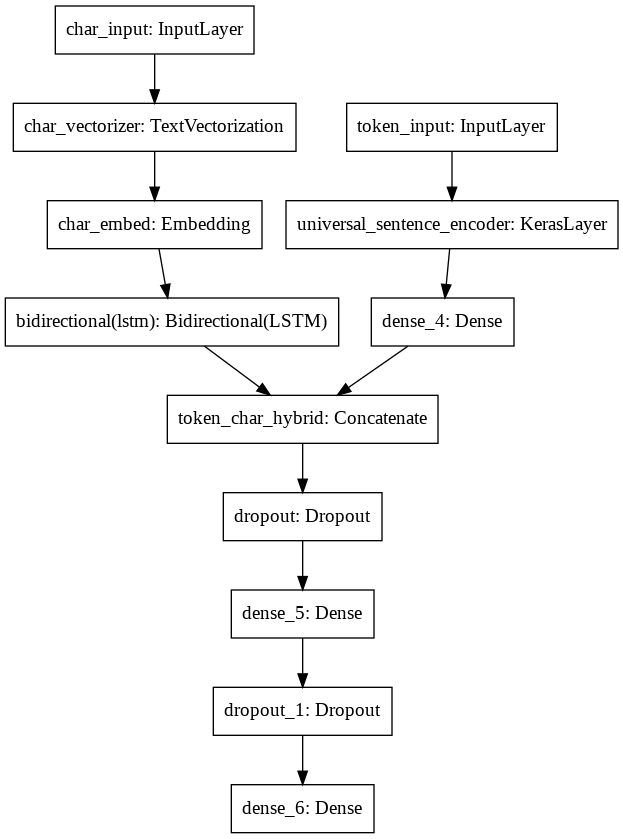

In [74]:
# Plot the hybrid token and character model 
from tensorflow.keras.utils import plot_model 
plot_model(model_4)

In [75]:
# Compile token char model 
model_4.compile(loss = 'categorical_crossentropy' , 
                optimizer = tf.keras.optimizers.Adam(), 
                metrics = ['accuracy'])

Now ot keep our experiments fast, we'll fit our token-character-hybrid model on 10% of training and validate on 10% of validation batches. 

To fit multiple inputs we can do this by create a tf.data.Dataset with a tuple as it's first input, for example:

```((token_data, char_data), (label))```

#### Combining token and character data into `tf.data.dataset`

In [76]:
# Combine chars and tokens into a dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences , train_chars)) # Make data 
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels 

train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data , train_char_token_labels))

# Applying prefetch and batching train data 
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat the same steps for validation data 
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences , valid_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)

val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data , val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_char_token_dataset , val_char_token_dataset

(<PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None,), (None,)), (None, 5)), types: ((tf.string, tf.string), tf.float64)>)

**Fitting a model on token and character level sequences**

In [77]:
# Fit the model on tokens and chars 
model_4_history = model_4.fit(train_char_token_dataset , 
                              steps_per_epoch = int(0.1 * len(train_char_token_dataset)) , 
                              epochs = 3 , 
                              validation_data = val_char_token_dataset , 
                              validation_steps = int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 35s 48ms/step - loss: 0.9802 - accuracy: 0.6107 - val_loss: 0.7776 - val_accuracy: 0.7051
Epoch 2/3
562/562 [==============================] - 24s 43ms/step - loss: 0.8031 - accuracy: 0.6895 - val_loss: 0.7188 - val_accuracy: 0.7257
Epoch 3/3
562/562 [==============================] - 23s 40ms/step - loss: 0.7776 - accuracy: 0.7015 - val_loss: 0.6892 - val_accuracy: 0.7424


In [78]:
# Evaluate on the whole validation dataset 
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.6928 - accuracy: 0.7371


[0.6927873492240906, 0.7370581030845642]

To make predictions for our multi-input model we can pass the `predict()` method a tuple of token-level sequences and character-level sequences. 

In our case we have a dataset to pass. 

In [79]:
# Make predictions using the token-character model hybrid 
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs 

array([[4.2468709e-01, 3.4793437e-01, 5.2287444e-03, 2.1671620e-01,
        5.4336977e-03],
       [3.9900488e-01, 4.2450136e-01, 3.3630319e-03, 1.7180096e-01,
        1.3297650e-03],
       [2.7612650e-01, 9.7277299e-02, 7.9066440e-02, 5.1994228e-01,
        2.7587513e-02],
       ...,
       [9.8876294e-04, 1.2843836e-02, 6.5481134e-02, 3.3270827e-04,
        9.2035359e-01],
       [9.4898120e-03, 5.7896454e-02, 3.1864953e-01, 3.5648614e-03,
        6.1039937e-01],
       [2.5599274e-01, 4.3896878e-01, 2.5114101e-01, 1.9394703e-02,
        3.4502763e-02]], dtype=float32)

In [80]:
# Turn prediction probabilties into prediction classes 
model_4_preds = tf.argmax(model_4_pred_probs , axis = 1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [121]:
# Getting the model_4 result 
model_4_results = calculate_metrics(val_labels_encoded , 
                                    model_4_preds)
model_4_results

{'Accuracy:': 73.70581226002912,
 'F1_Score: ': 0.734815184844525,
 'Precision: ': 0.737292702483079,
 'Recall: ': 0.7370581226002912}

**Feature Engineering**
- Taking non-obvious features from the data and encoding them numerically to help our models learn. 
- How can we add extra sources of data to our model.


### Model 5: Transfer Learning with pretrained token embeddings + character embeddings + positional embeddings. 

It seems like combining token and character embeddings gave our model a little performance boost.

But if we do some feature engineering and create a feature that were to look at an abstract, and figure ot the sentence in order. Because each sentences should be in different order to make sense and if they were to appear sequentially then it wouldnt make sense. 

For example, sequences labelled CONCLUSIONS at the beginning and sequences labelled OBJECTIVE at the end?

Abstracts typically come in a sequential order, such as:

- OBJECTIVE ...
- METHODS ...
- METHODS ...
- METHODS ...
- RESULTS ...
- CONCLUSIONS ...

Or

- BACKGROUND ...
- OBJECTIVE ...
- METHODS ...
- METHODS ...
- RESULTS ...
- RESULTS ...
- CONCLUSIONS ...
- CONCLUSIONS ...


You might've noticed this when we created our preprocess_text_with_line_numbers() function. When we read in a text file of abstracts, we counted the number of lines in an abstract as well as the number of each line itself.

Doing this led to the "line_number" and "total_lines" columns of our DataFrames.

In [81]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


The `line_number` and `total_lines` columns are features which didn't necessarily come with the training data but can be passed to our model as a **positional embedding**. 

In other words, the positional embedding is where the sentence appears in the abstract. 

> **🛠 Exercise:** Another way of creating our positional embedding feature would be to combine the "line_number" and "total_lines" columns into one, for example a "line_position" column may contain values like 1_of_11, 2_of_11, etc. Where 1_of_11 would be the first line in an abstract 11 sentences long. After going through the following steps, you might want to revisit this positional embedding stage and see how a combined column of "line_position" goes against two separate columns.

#### Create positional embeddings 

Since our `"line_number"` and `"total_line"` columns are already numerical, we could pass them as they are to our model.

But to avoid our model thinking a line with `"line_number"=5` is five times greater than a line with `"line_number"=1`, we'll use one-hot-encoding to encode our "line_number" and `"total_lines"` features.

To do this, we can use the `tf.one_hot` utility.

tf.one_hot returns a one-hot-encoded tensor. It accepts an array (or tensor) as input and the depth parameter determines the dimension of the returned tensor.

To figure out what we should set the depth parameter to, let's investigate the distribution of the "line_number" column.

In [82]:
# How many different line numbers are there? 
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

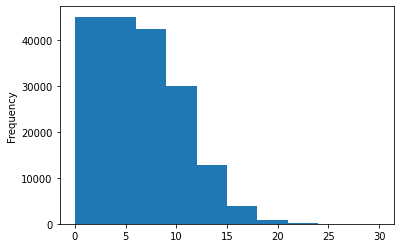

In [83]:
# Check the distribution of line_number column 
train_df.line_number.plot.hist()

In [84]:
# Use TensorFlow to create one hot encoded tensors of our "line_number" column 
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy() , depth= 15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy() , depth= 15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy() , depth= 15)

In [85]:
train_line_numbers_one_hot[:10] , train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(10, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]],
       dtype=float32)>, TensorShape([180040, 15]))

In [86]:
# Doing the same for the total lines 
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

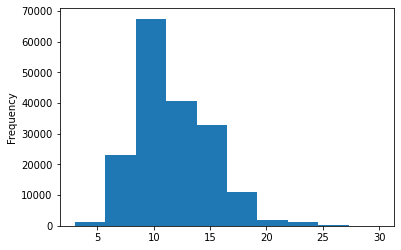

In [88]:
# Checking the distribution 
train_df['total_lines'].plot.hist()

Lookin at the distribution of our total line column, a value of 20 looks like it covers the majority of samples. 

Lets confirm it by using the percentile

In [89]:
# Check the coverage of a total_lines value of 20 
np.percentile(train_df.total_lines , 98)

20.0

In [93]:
# Use TensorFlow to create one-hot-encoded tensors of our "total_lines" column 
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)

# Check shape and samples of total lines one-hot tensor
train_total_lines_one_hot.shape, train_total_lines_one_hot[:10]

(TensorShape([180040, 20]), <tf.Tensor: shape=(10, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0.

#### **Building a Tribid Embedding model**

1. Create a token-level model 
2. Create a character level model 
3. Create a model for the `line_number` feature 
4. Create a model for the `total_line` feature
5. Combine the outputs of step 1 and 2 using the concatenate layer. 
6. Now combine the outputs of 3,4,5 using the concatenate layer. 
7. Create an output layer to accept the tribid embedding and output label probabilities. 
8. Combine the inputs of 1,2,3,4 and the outputs of 7 into a `tf.keras.Model`

In [109]:
# 1. Token inputs 
token_inputs = layers.Input(shape = [], dtype = tf.string , name='token_inputs')
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_outputs = layers.Dense(128 , activation = 'relu' , name = 'token_outputs')(token_embeddings)
token_model = tf.keras.Model(inputs = token_inputs , 
                             outputs = token_outputs)

# 2. Char Inputs 
char_inputs = layers.Input(shape = (1,), dtype = tf.string , name = 'char_inputs')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs = char_inputs , 
                            outputs = char_bi_lstm)

# 3. Model for the line_number feature 
line_inputs = layers.Input(shape = (15,) , name='line_number_inputs')
line_dense = layers.Dense(128 , activation = 'relu')(line_inputs)
line_model = tf.keras.Model(inputs = line_inputs , 
                            outputs= line_dense)

# 4. Model for the total_number feature 
total_num_inputs = layers.Input(shape = (20,) , name='total_number_inputs')
total_num_dense = layers.Dense(32 , activation = 'relu')(total_num_inputs)
total_num_model = tf.keras.Model(inputs = total_num_inputs , 
                                 outputs = total_num_dense)

# 5. Combine the token and char embeddings into a hybrid model 
combined_embeddings = layers.Concatenate(name = 'char_token_hybrid_embedding')([token_model.output , 
                                                                                char_model.output])

z = layers.Dense(256 , activation= 'relu')(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. Combine positional embedding with combined token and char embeddings 
tribid_embeddings = layers.Concatenate(name = 'char_token_positional_embedding')([line_model.output , 
                                                                                  total_num_model.output , 
                                                                                  z])

# 7. Create output layer 
output_layer = layers.Dense(5 , activation= 'softmax' ,name = 'output_layer')(tribid_embeddings)

# 8. Put together into a whole Model 
model_5 = tf.keras.Model(inputs = [line_model.input , 
                                   total_num_model.inputs , 
                                   token_model.input , 
                                   char_model.input] , 
                         outputs = output_layer)

# Getting the summary of the model 
model_5.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_inputs (InputLayer)        [(None, 1)]          0                                            
__________________________________________________________________________________________________
token_inputs (InputLayer)       [(None,)]            0                                            
__________________________________________________________________________________________________
char_vectorizer (TextVectorizat (None, 290)          0           char_inputs[0][0]                
__________________________________________________________________________________________________
universal_sentence_encoder (Ker (None, 512)          256797824   token_inputs[0][0]               
___________________________________________________________________________________________

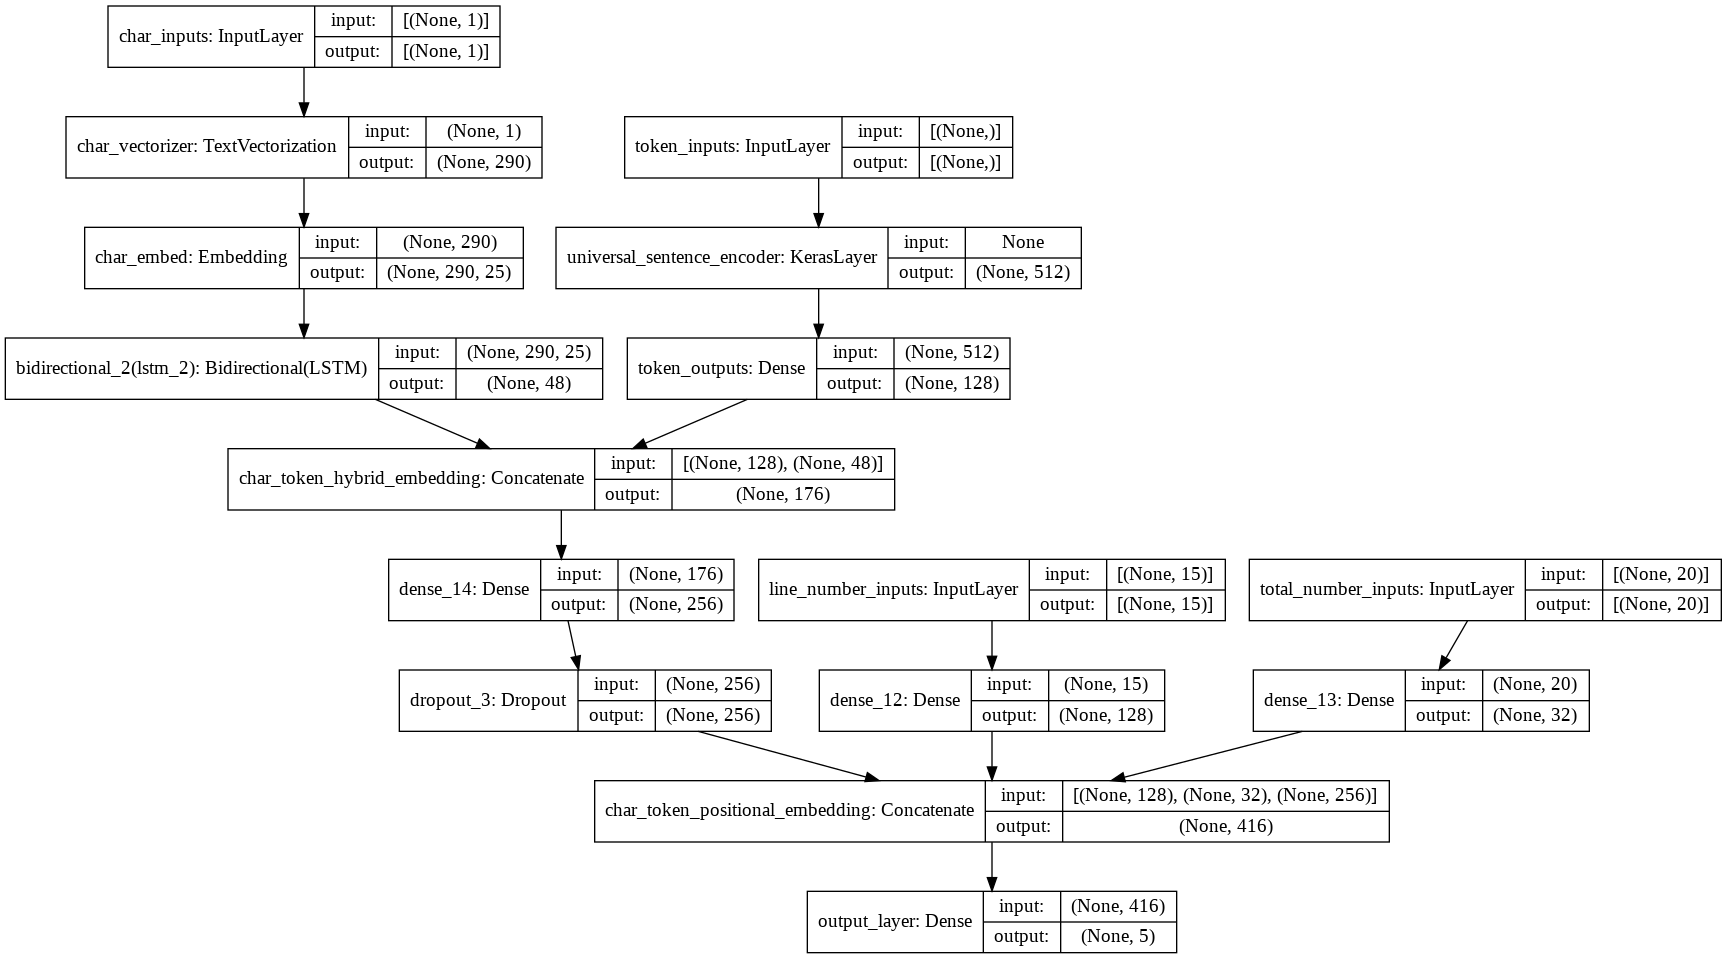

In [110]:
# Plotting the model architecture 
from tensorflow.keras.utils import plot_model
plot_model(model_5 , show_shapes= True)

What is label smoothing?

For example if our model gets too confident on a single class (e.g its prediction probability is really high), it may get stuck on that class and not consider other classes. 

Really Confident: `[0.0 , 0.0 , 1.0 , 0.0 , ]`

What labeel smoothing does is it assigns some of the alue from the most confident or highest pred prob to other classes, in turn, hopefully improving generalization: `[0.01 , 0.01 , 0.96 , 0.01 , 0.01]`

https://www.pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [111]:
# Compile token, char and positional embedding model 
model_5.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing= 0.2) , 
              optimizer = tf.keras.optimizers.Adam(), 
              metrics = ['accuracy'])

#### Create tribit embedding datasets and fit tribid model 

1. Train line numbers one-hot tensor (train_line_numbers_one_hot)
2. Train total lines one-hot tensor (train_total_lines_one_hot)
3. Token-level sequences tensor (train_sentences)
4. Char-level sequences tensor (train_chars)


In [106]:
# Create training and validation dataset + Batching and adding Prefetch
train_pos_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot , 
                                                                train_total_lines_one_hot , 
                                                                train_sentences , 
                                                                train_chars))

train_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_pos_char_token_dataset = tf.data.Dataset.zip((train_pos_char_token_data , train_pos_char_token_labels))
train_pos_char_token_dataset = train_pos_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Same for the validation set 
val_pos_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot , 
                                                              val_total_lines_one_hot , 
                                                              val_sentences , 
                                                              valid_chars))

val_pos_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_pos_char_tokens_dataset = tf.data.Dataset.zip((val_pos_char_token_data , val_pos_char_token_labels))
val_pos_char_tokens_dataset = val_pos_char_tokens_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Check input shapes
train_pos_char_token_dataset, val_pos_char_tokens_dataset

(<PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>,
 <PrefetchDataset shapes: (((None, 15), (None, 20), (None,), (None,)), (None, 5)), types: ((tf.float32, tf.float32, tf.string, tf.string), tf.float64)>)

In [112]:
# Fit the token, char and positional embedding model
history_model_5 = model_5.fit(train_pos_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_pos_char_token_dataset)),
                              epochs=3,
                              validation_data=val_pos_char_tokens_dataset,
                              validation_steps=int(0.1 * len(val_pos_char_token_dataset)))

Epoch 1/3
562/562 [==============================] - 42s 48ms/step - loss: 1.0669 - accuracy: 0.7436 - val_loss: 1.0061 - val_accuracy: 0.7083
Epoch 2/3
562/562 [==============================] - 24s 43ms/step - loss: 0.9614 - accuracy: 0.8206 - val_loss: 0.9904 - val_accuracy: 0.7604
Epoch 3/3
562/562 [==============================] - 21s 38ms/step - loss: 0.9469 - accuracy: 0.8258 - val_loss: 0.9511 - val_accuracy: 0.8333


In [113]:
# Evaluate on the whole data 
model_5.evaluate(val_pos_char_tokens_dataset)

945/945 [==============================] - 21s 22ms/step - loss: 0.9339 - accuracy: 0.8367


[0.9339377284049988, 0.8366873860359192]

In [115]:
# Make predictions with token-char-positional hybrid model
model_5_pred_probs = model_5.predict(val_pos_char_tokens_dataset, verbose=1)
model_5_pred_probs

945/945 [==============================] - 22s 21ms/step


array([[0.4957591 , 0.11704955, 0.00938569, 0.3598904 , 0.01791536],
       [0.546257  , 0.09667032, 0.04444989, 0.30366483, 0.00895795],
       [0.292059  , 0.11821546, 0.11931445, 0.40207157, 0.06833944],
       ...,
       [0.03746393, 0.10311833, 0.03856545, 0.03216388, 0.78868836],
       [0.02864516, 0.30293345, 0.08533233, 0.0256525 , 0.5574366 ],
       [0.16867526, 0.59758013, 0.11854637, 0.04184427, 0.07335397]],
      dtype=float32)

In [116]:
# Turn prediction probabilities into prediction classes
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [120]:
# Calculate results of token-char-positional hybrid model
model_5_results = calculate_metrics(y_true=val_labels_encoded,
                                    y_preds=model_5_preds)
model_5_results

{'Accuracy:': 83.66874089765656,
 'F1_Score: ': 0.8353467196243924,
 'Precision: ': 0.8360461875325029,
 'Recall: ': 0.8366874089765656}

### Compare Model Results 

Now after building fair few models, lets compare each models performance against each other. 

In [122]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "custom_token_embed_conv1d": model_1_results,
                                  "pretrained_token_embed": model_2_results,
                                  "custom_char_embed_conv1d": model_3_results,
                                  "hybrid_char_token_embed": model_4_results,
                                  "tribrid_pos_char_token_embed": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,Accuracy:,F1_Score:,Precision:,Recall:
baseline,72.183238,0.698925,0.718647,0.721832
custom_token_embed_conv1d,80.679862,0.804952,0.804905,0.806799
pretrained_token_embed,71.259764,0.709587,0.713073,0.712598
custom_char_embed_conv1d,66.652324,0.658605,0.662077,0.666523
hybrid_char_token_embed,73.705812,0.734815,0.737293,0.737058
tribrid_pos_char_token_embed,83.668741,0.835347,0.836046,0.836687


In [125]:
# Reduce the accuracy to same scale as other metrics
all_model_results["Accuracy:"] = all_model_results["Accuracy:"]/100

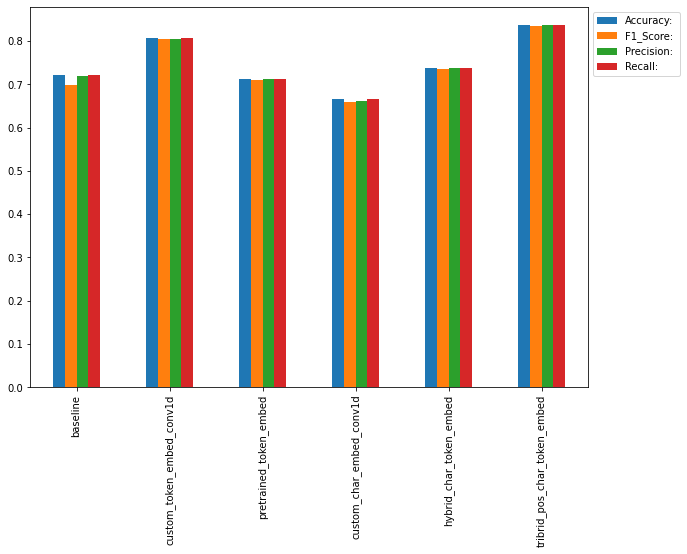

In [126]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));